Alright, I lied. One more exploratory plot - Hovmoller plot of different rainfall types, and then a summary plot showing the area average - essentially, showing seasonality.

In [2]:
import itertools
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import time
import os
from shutil import copy

%matplotlib inline
%load_ext autotime


from jd_matplotlib_tools import add_double_calendar_axis, mark_time_periods

In [3]:
ferretpath = "/Users/Siwen/Desktop/ferret/bin"
rdapath = "APHRO_ZH_front_025deg_V1101."

time: 768 µs


In [4]:
## start by loading all precipitation data for each year.
P = np.zeros((365,80,72,57))
P_band = np.zeros((365,80,72,57))
P_local = np.zeros((365,80,72,57))

for yr in range(1951,2008):
    
    #Build filename
    filename = ferretpath + '/' + rdapath + str(yr) + '.nc'
    print(filename),
    myf = nc.Dataset(filename, 'r')
    
    #Obtain fraction of different types of rainfall
    P[:,:,:,yr-1951] = myf['P'][:365,:,:]
    P_band[:,:,:,yr-1951] = myf['P_band1'][:365,:,:] + myf['P_band2'][:365,:,:]
    P_local[:,:,:,yr-1951] = myf['P_leftover'][:365,:,:]
    
    myf.close()
    
P_tuple = (P,P_band,P_local)
P_mean = [ np.nanmean(P_type, axis=(2,3)) for P_type in P_tuple ]

/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1951.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1952.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1953.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1954.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1955.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1956.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1957.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1958.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1959.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1960.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1961.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1962.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1963.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_025deg_V1101.1964.nc
/Users/Siwen/Desktop/ferret/bin/APHRO_ZH_front_0

In [5]:
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

time: 6.34 ms


In [6]:
## SMOOTHING ##
#smooth out the decadal precipitation means
#but, no latitudinal smoothing since rainfall already effectively smoothed in latitude
daysmth = 15
latsmth = 0

P_smth = [ smooth(x,daysmth,latsmth) for x in P_mean ]

time: 2.03 s


In [7]:
## DEFINE TIME PERIODS OF INTEREST
time_periods = [[80.5,120.5],[120.5,160.5],[160.5,200.5],[200.5,273.5],[273.5,320.5]]

time: 914 µs


In [8]:
## OBTAIN AREA AVERAGE
P_area = [np.mean(P, axis=1) for P in P_smth]

time: 1.34 ms


/Users/Siwen/anaconda/lib/python3.6/site-packages/matplotlib/text.py:2138: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


Overwriting existing version of file in RDA manuscript directory...
Overwriting existing version of file in RDA Python directory...


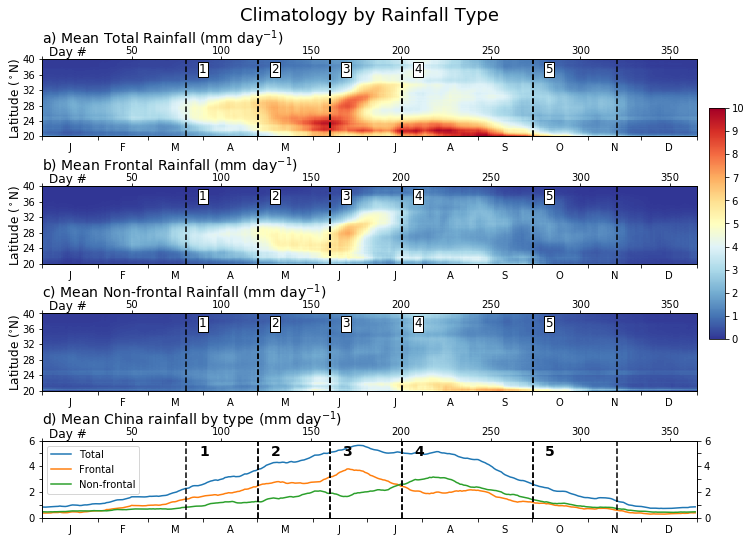

time: 46.5 s


In [15]:
# CREATE CLIMATOLOGY FIGURE
mypalette = 'RdYlBu_r'

## Set up axis and title for the entire figure
fig, ax = plt.subplots(figsize=(11,8))
ax.set_title("Climatology by Rainfall Type", fontsize=18, y = 1.07, x=.5)
ax.set_axis_off()

## Subplot a) - Total rainfall
ax1 = fig.add_subplot(4,1,1)
plot1 = ax1.pcolormesh(P_smth[0].T, cmap = mypalette, vmin = 0, vmax = 10); 
ax1.set_title("a) Mean Total Rainfall (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$N)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')


## Subplot b) - Banded rainfall
ax2 = fig.add_subplot(4,1,2)
plot2 = ax2.pcolormesh(P_smth[1].T, cmap = mypalette, vmin = 0, vmax = 10); 
ax2.set_title("b) Mean Frontal Rainfall (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
plt.ylabel('Latitude ($^\circ$N)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')


## Subplot c) Local rainfall
ax3 = fig.add_subplot(4,1,3)
plot3 = ax3.pcolormesh(P_smth[2].T, cmap = mypalette, vmin = 0, vmax = 10); 
plt.ylabel('Latitude ($\!^\circ\!$N)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))
ax3.set_title("c) Mean Non-frontal Rainfall (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')

## Subplot d) Mean China Rainfall by Type
ax4 = fig.add_subplot(4,1,4)
labels = ['Total','Frontal','Non-frontal']
for P, lab in zip(P_area, labels):
    plt.plot(P, label=lab)
    
#plt.ylabel('Latitude ($\!^\circ\!$N)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,6,7))
ax4.set_yticklabels(['0','','2','','4','','6'])
ax4.yaxis.tick_right()
ax4.yaxis.set_ticks_position('both')
ax4.tick_params(labelleft=True,labelright=True)
ax4.set_title("d) Mean China rainfall by type (mm day$^{-1}$)", fontsize=14, y=1.12, loc = 'left')
handles, labels = ax4.get_legend_handles_labels()
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, fontsize = 10)

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes', box = 'no')

#tighten up plot layout
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([.915, 0.37, 0.02, 0.4])
cbar = fig.colorbar(plot2, cax = cbar_ax, ticks=np.linspace(0,10,11))
#cbar.ax.set_yticklabels()  # customize labels on joint color bars


## SAVE COPIES OF FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "hov_types_climo.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')